In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

from typing import Tuple

In [2]:
def func(x: float) -> float:
    return 1 / (1 + 25 * x ** 2)

In [3]:
def generate_data(
    l: int = 100, noise: bool = False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    xl = []
    yl = []
    for i in range(1, l + 1):
        x = 4.0 * (float(i) - 1) / (float(l) - 1) - 2.0
        xl.append(x)
        yl.append(func(x) + np.random.normal(0, 0.1) if noise else func(x))

    xk = []
    yk = []
    for i in range(1, l + 1):
        x = 4.0 * (float(i) - 0.5) / (float(l) - 1) - 2.0
        xk.append(x)
        yk.append(func(x) + np.random.normal(0, 0.1) if noise else func(x))

    return xl, yl, xk, yk

In [4]:
Xl, Yl, Xk, Yk = generate_data()

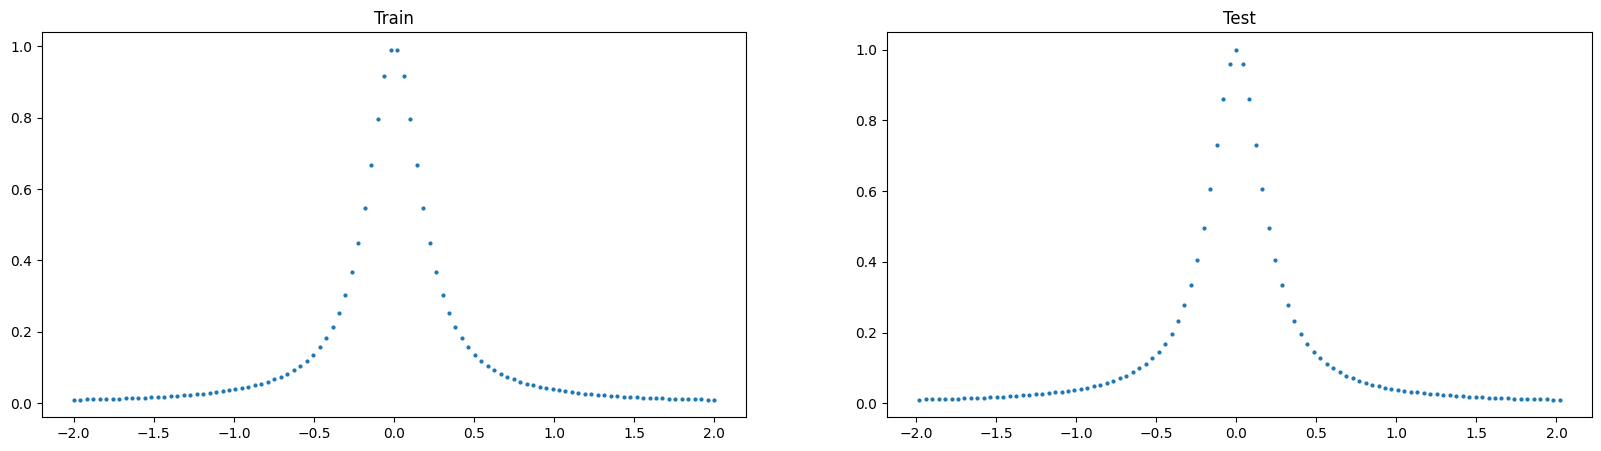

In [5]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.scatter(Xl, Yl, s=4)
plt.title('Train')

plt.subplot(122)
plt.scatter(Xk, Yk, s=4)
plt.title('Test')

plt.show()

In [6]:
points_count = 100
_noise_scale = 0.05

noise_ = np.random.normal(0, _noise_scale, points_count)
np.random.shuffle(noise_)
for i in range(len(Yl)):
    Yl[i] += noise_[i]
for i in range(len(Yk)):
    Yk[i] += noise_[i]

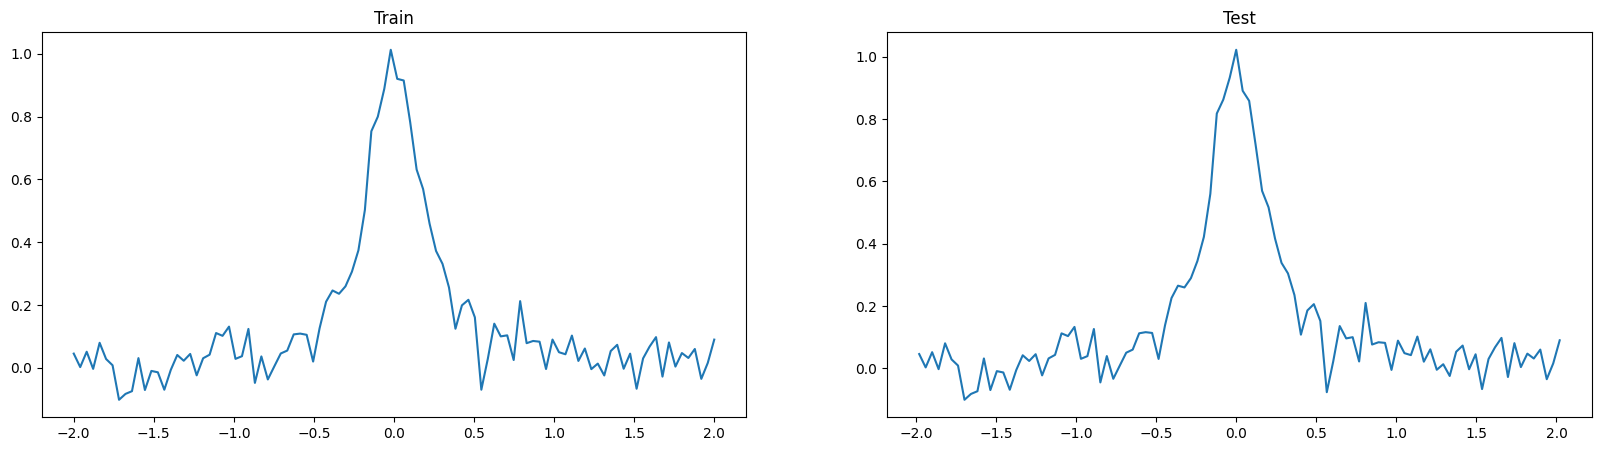

In [7]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(Xl, Yl)
plt.title('Train')

plt.subplot(122)
plt.plot(Xk, Yk)
plt.title('Test')

plt.show()

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

Рассмотрим феномен Рунге

In [9]:
Xl = np.array(Xl).reshape(-1, 1)
Xk = np.array(Xk).reshape(-1, 1)

In [10]:
def compare_polynomial_regressors(xl, yl, xk, yk):
    plt.figure(figsize=(20,40))
    index = 1

    min_error = 100
    optimal_degree = 1

    train_mse_list = []
    test_mse_list = []

    r = range(1, 30)

    for degree in r:
        model = Pipeline(
            [
                ('poly', PolynomialFeatures(degree=degree)),
                ('linear', LinearRegression(fit_intercept=True))
            ]
        )
        model = model.fit(xl, yl)

        yl_pred = model.predict(xl)
        yk_pred = model.predict(xk)

        train_error = mean_squared_error(yl, yl_pred)
        test_error = mean_squared_error(yk, yk_pred)
        train_mse_list.append(train_error)
        test_mse_list.append(test_error)

        plt.subplot(30, 2, index)
        plt.plot(xl, yl, color='green', label='original')
        plt.plot(xl, yl_pred, color='red', label='predicted')
        plt.title(f'Train approximation with degree={degree}. MSE = {round(train_error, 3)}')
        plt.legend()

        plt.subplot(30, 2, index + 1)
        plt.plot(xl, yl, color='green', label='original')
        plt.plot(xk, yk_pred, color='red', label='predicted')
        plt.title(f'Test approximation with degree={degree}. MSE = {round(test_error, 3)}')
        plt.legend()
        index += 2

        if min_error > test_error:
            min_error = test_error
            optimal_degree = degree

    print(f'Optimal degree is {optimal_degree} with MSE = {min_error}')
    plt.show()


    plt.plot(list(r), train_mse_list, label='train mse')
    plt.plot(list(r), test_mse_list, label='test mse')
    plt.legend()
    plt.show()

    return optimal_degree

Optimal degree is 23 with MSE = 0.0029012808508957445


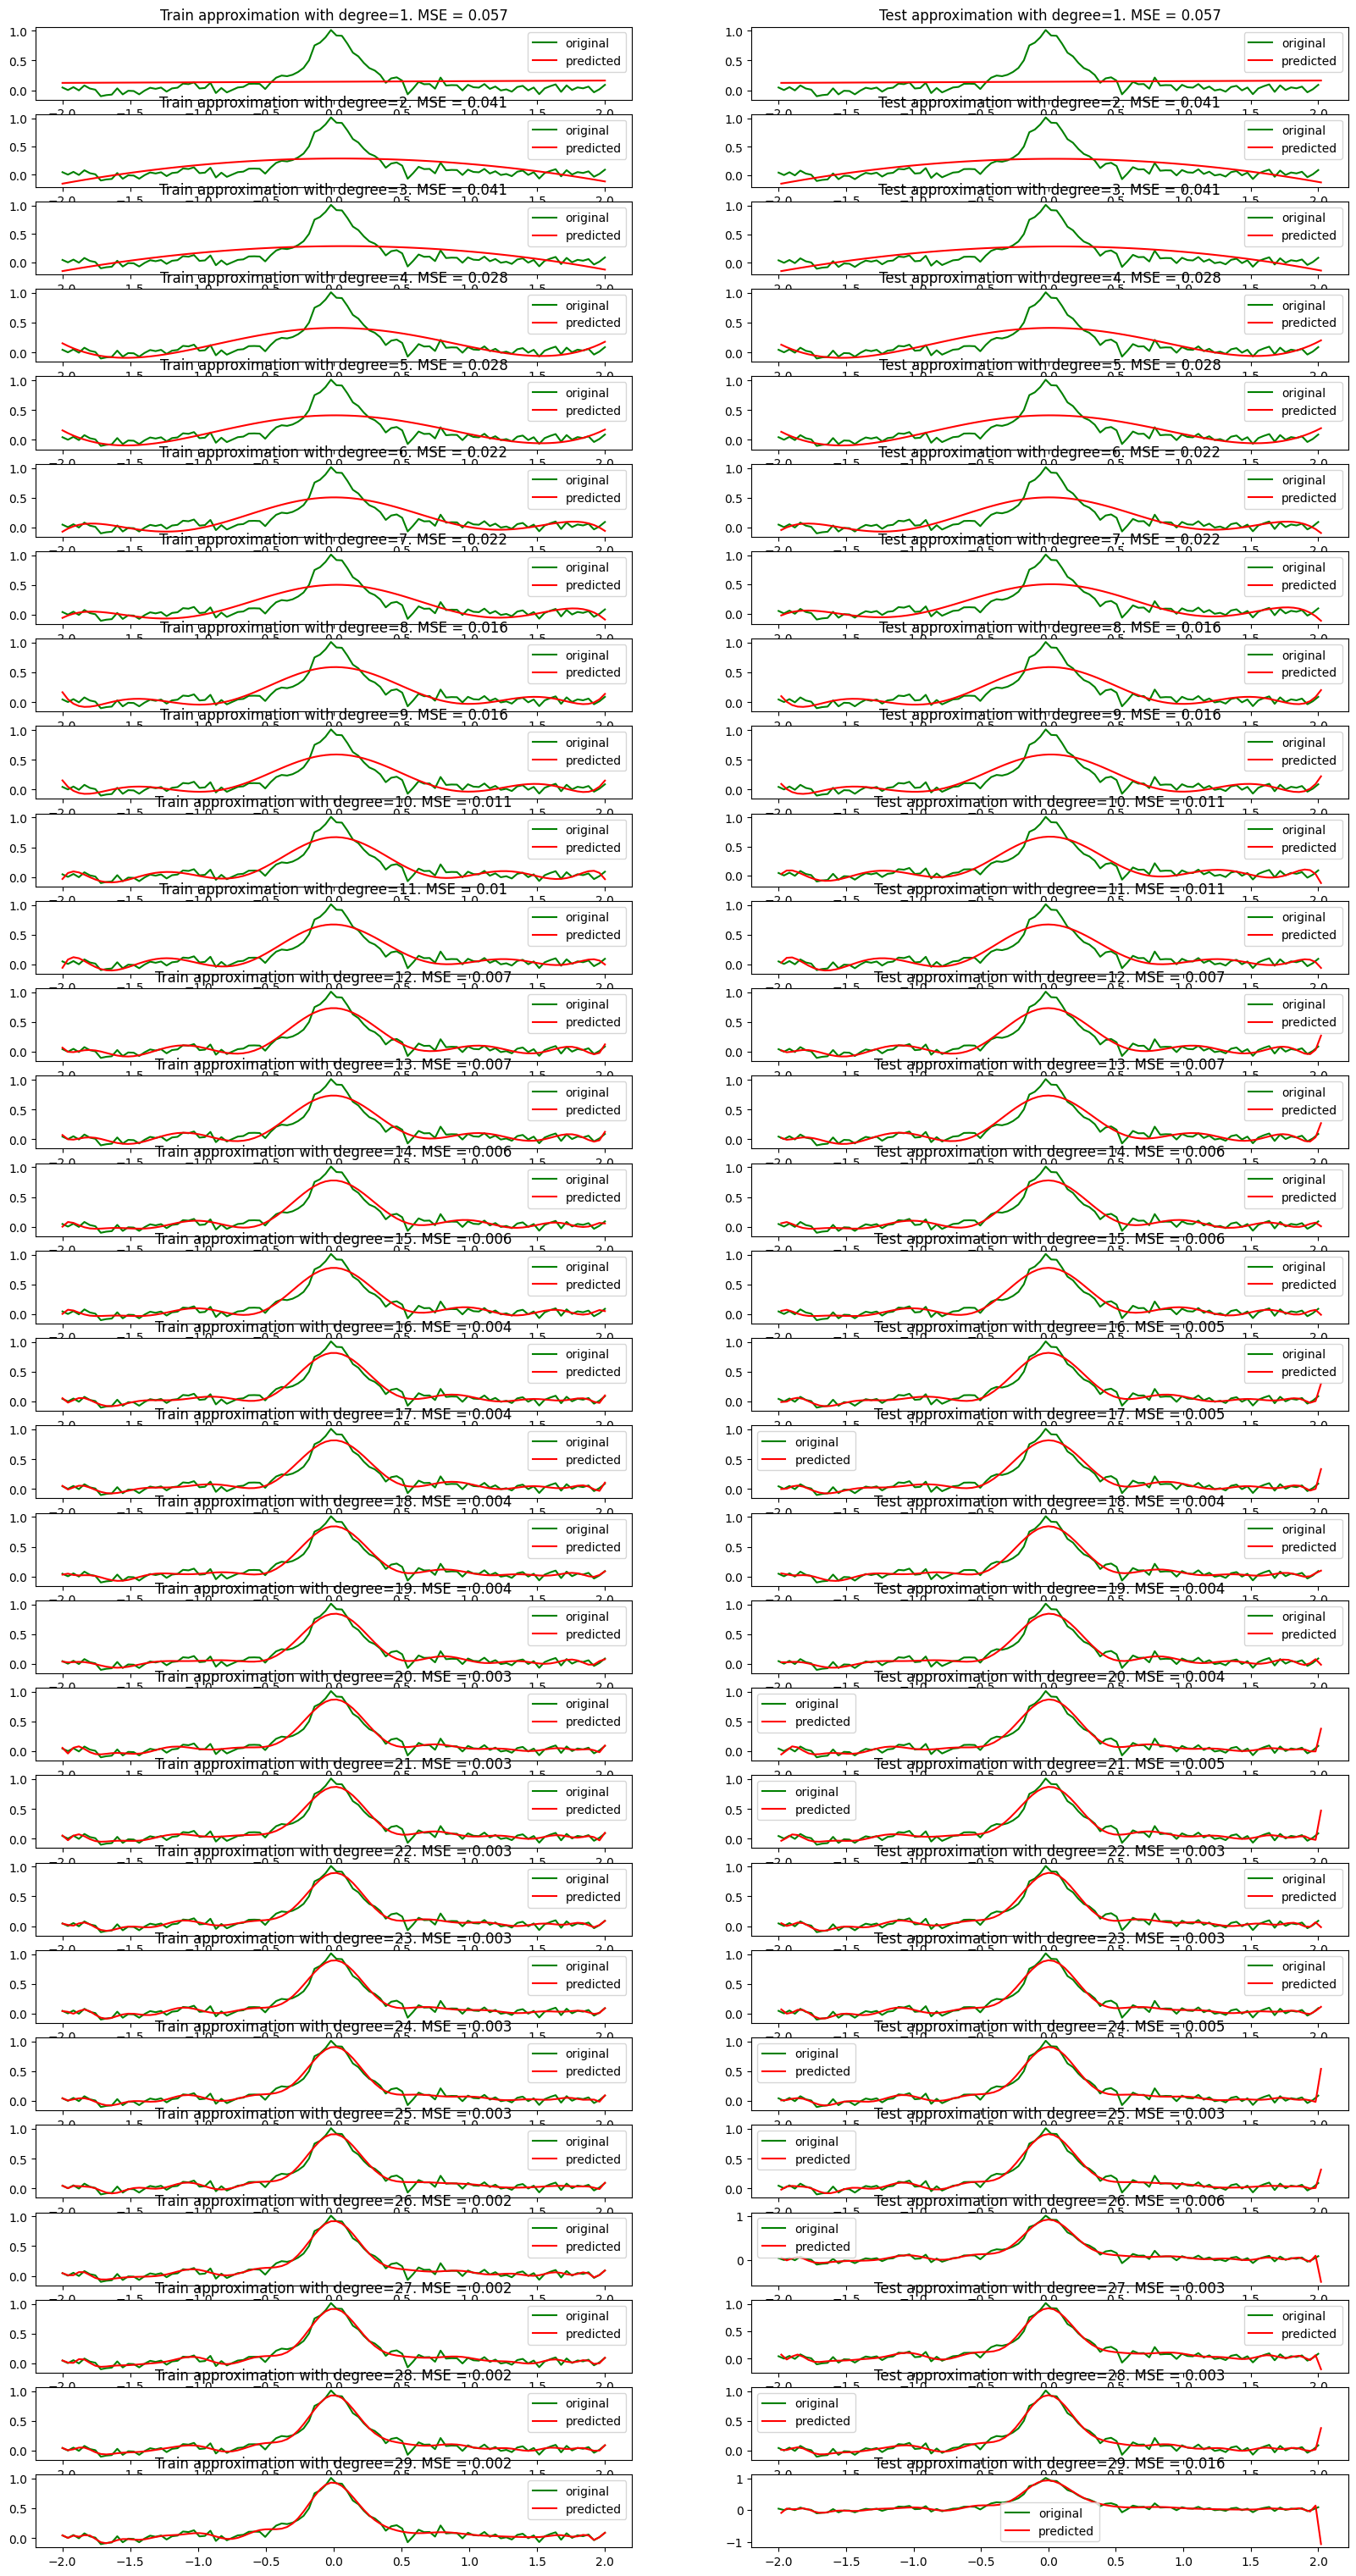

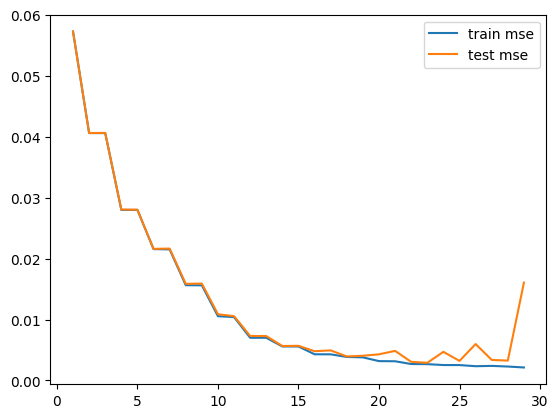

In [11]:
optimal_degree = compare_polynomial_regressors(Xl, Yl, Xk, Yk)

Оптимизация коэффициентов с помощью генетического алгоритма

In [12]:
optimal_degree

23

In [13]:
optimal_degree = 8

In [14]:
model = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=optimal_degree)),
        ('linear', LinearRegression(fit_intercept=True))
    ]
)
model = model.fit(Xl, Yl)
yk_pred = model.predict(Xk)
print(f'MSE: {round(mean_squared_error(Yk, yk_pred), 5)}')

MSE: 0.01586


In [15]:
poly: PolynomialFeatures = model['poly']
lin_model: LinearRegression = model['linear']

In [16]:
xl_poly = poly.fit_transform(Xl)
xk_poly = poly.fit_transform(Xk)

In [17]:
coefs = lin_model.coef_
coefs[0] = lin_model.intercept_

In [18]:
res = np.sum(coefs * xk_poly, axis=1)
mean_squared_error(Yk, res)

0.015860097098902282

In [19]:
from geneticalgorithm2 import geneticalgorithm2 as ga, AlgorithmParams

In [20]:
def optimization_func(new_coefs: np.array):
    res = np.sum(new_coefs * xk_poly, axis=1)
    return mean_squared_error(Yk, res)

In [21]:
start_coefs = coefs
count_coefs = len(start_coefs)

In [22]:
start_coefs.min(), start_coefs.max()

(-1.646990277640675, 1.464976330083192)

In [34]:
varbound = np.array([[-3,3]] * count_coefs)

In [35]:
ga_model=ga(
    function=optimization_func,
    dimension=count_coefs,
    variable_type='real',
    variable_boundaries=varbound,
    algorithm_parameters=AlgorithmParams(
        max_num_iteration=2000,
        population_size=1500,
        mutation_probability=1,
        elit_ratio=0.6,
        parents_portion=0.7,
    )
)


Set: Average time of function evaluating (secs): 0.000489419937133789 (total = 0.7341299057006836)

Best score before optimization: 37.64983087472195
                                                                                                                                                                                                        
 The best found solution:
 [ 0.26190041  0.0527276  -0.14121163  0.09010112 -0.13099741 -0.08792029
  0.10563323  0.01660615 -0.01770993]

 Objective function:
 0.038170404463126764

 Used generations: 2000
 Used time: 384 seconds


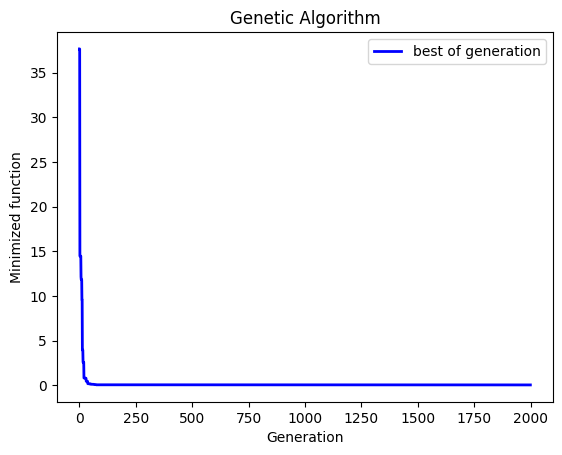

In [36]:
upd_result = ga_model.run()

Objective func: 8011 / 1.189 / 0.642 / 0.0539 / 0.0489 / 0.0439 / 0.0381

In [37]:
best_coefs = ga_model.result.last_generation.variables[0]
best_coefs

array([ 0.26190041,  0.0527276 , -0.14121163,  0.09010112, -0.13099741,
       -0.08792029,  0.10563323,  0.01660615, -0.01770993])

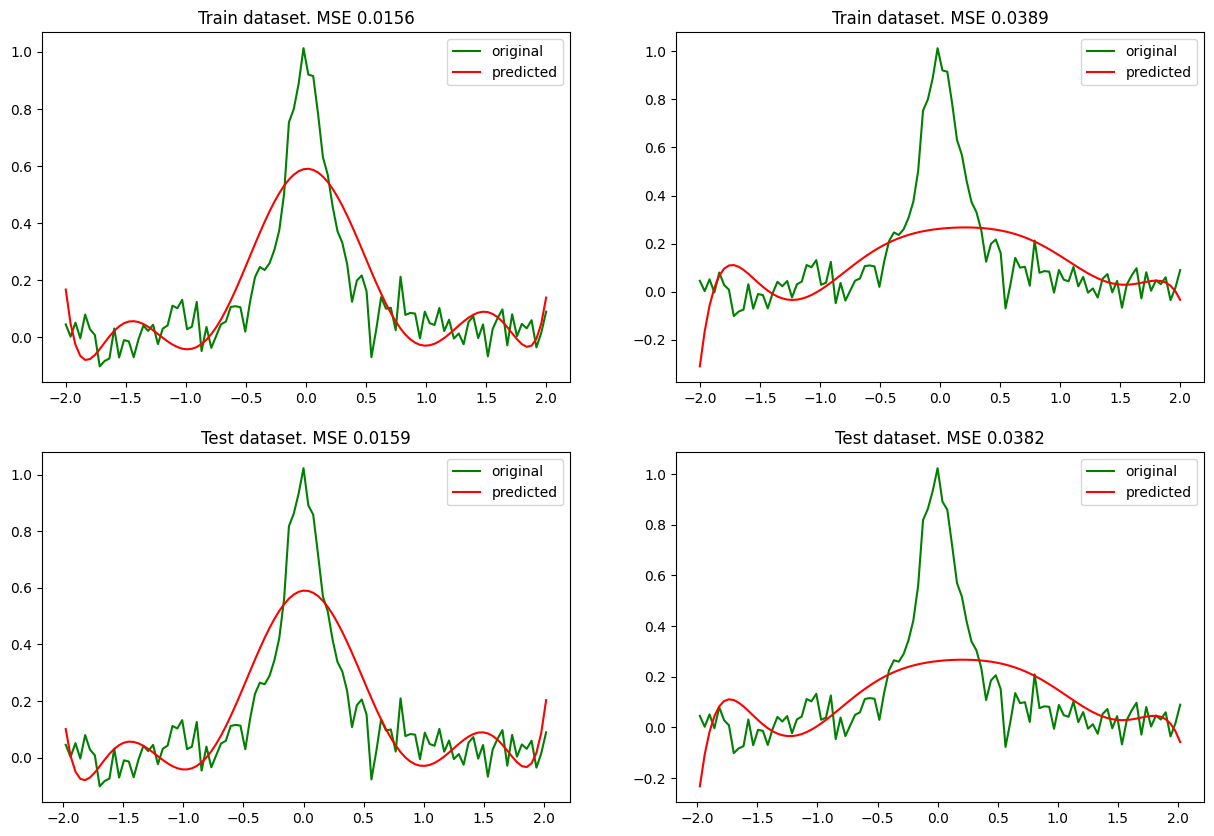

In [38]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
values = np.sum(start_coefs * xl_poly, axis=1)
plt.plot(Xl, Yl, color='green', label='original')
plt.plot(Xl, values, color='red', label='predicted')
plt.title(f'Train dataset. MSE {round(mean_squared_error(Yl, values), 4)}')
plt.legend()

plt.subplot(222)
values = np.sum(best_coefs * xl_poly, axis=1)
plt.plot(Xl, Yl, color='green', label='original')
plt.plot(Xl, values, color='red', label='predicted')
plt.title(f'Train dataset. MSE {round(mean_squared_error(Yl, values), 4)}')
plt.legend()

plt.subplot(223)
values = np.sum(start_coefs * xk_poly, axis=1)
plt.plot(Xk, Yk, color='green', label='original')
plt.plot(Xk, values, color='red', label='predicted')
plt.title(f'Test dataset. MSE {round(mean_squared_error(Yk, values), 4)}')
plt.legend()

plt.subplot(224)
values = np.sum(best_coefs * xk_poly, axis=1)
plt.plot(Xk, Yk, color='green', label='original')
plt.plot(Xk, values, color='red', label='predicted')
plt.title(f'Test dataset. MSE {round(mean_squared_error(Yk, values), 4)}')
plt.legend()

plt.show()